In [1]:
! pip install segmentation_models
! pip install albumentations

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import normalize
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import model_utility


#path sorting
import glob
import cv2
from pathlib import Path
import re

#math
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

Segmentation Models: using `keras` framework.


# What are we doing today?

In [2]:
model_path = "models/"
type = "darkAug"
training_size = "360"
epoch_num = "300"
backbone = "resnet34"

# Create training data

In [3]:
X, Y = [], []

X, Y = model_utility.data_gather(X, Y, "dark_spokes_training_images", "dark_spokes_training_masks", aug_flag = 1, aug_num = 5)

360 360


In [7]:
X = normalize(np.array(X), axis=1)
Y = (np.array(Y))/255.

# train/test split test_size = .15 for light, .25 for dark(no agu)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.14, random_state = 42)

SIZE_Y, SIZE_X = X.shape[1], X.shape[2]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(309, 160, 736)
(51, 160, 736)
(309, 160, 736)
(51, 160, 736)


In [8]:
# model = sm.Unet(backbone_name="resnet34", encoder_weights = None, input_shape=(SIZE_Y,SIZE_X, 1))
# model.compile(optimizer = "Adam" , loss = "binary_crossentropy", metrics = [sm.metrics.IOUScore()], )
# print(model.summary())

model = model_utility.define_model(SIZE_Y, SIZE_X, backbone)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 736, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 736, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 742, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 80, 368, 64)  3136        ['zero_padding2d[0][0]']   

In [9]:
history = model_utility.fit_model(x_train, y_train, model, batch_size = 10,epochs = 300, validation_split = .16)


Epoch 1/300
26/26 [==============================] - 22s 462ms/step - loss: 0.3841 - iou_score: 3.3945e-09 - val_loss: 4.1575 - val_iou_score: 3.2591e-09
Epoch 2/300
26/26 [==============================] - 8s 322ms/step - loss: 0.1312 - iou_score: 3.8718e-09 - val_loss: 0.1238 - val_iou_score: 1.0973e-09
Epoch 3/300
26/26 [==============================] - 8s 322ms/step - loss: 0.0581 - iou_score: 4.0647e-09 - val_loss: 0.0540 - val_iou_score: 7.4242e-10
Epoch 4/300
26/26 [==============================] - 8s 323ms/step - loss: 0.0330 - iou_score: 4.2238e-09 - val_loss: 0.0360 - val_iou_score: 1.8684e-09
Epoch 5/300
26/26 [==============================] - 8s 322ms/step - loss: 0.0218 - iou_score: 4.2741e-09 - val_loss: 0.0605 - val_iou_score: 2.7335e-09
Epoch 6/300
26/26 [==============================] - 8s 324ms/step - loss: 0.0155 - iou_score: 4.4385e-09 - val_loss: 0.0380 - val_iou_score: 2.8197e-09
Epoch 7/300
26/26 [==============================] - 8s 325ms/step - loss: 0.0117

In [ ]:
# THIS IS - LIGHT SPOKES

# Model Notes

In [ ]:
## NO AUG
#BOTH
# At least the both one can learn more after 1000 epochs, likely others can as well

#LIGHT
# How works on light? - good
# how works on dark? - detects light parts of image, but no spokes

#DARK
# How works on light? - good
# how works on dark? - detects dark part of light image, but no spokes

## AUG

# Plots

In [10]:
results = model.evaluate(x_test, y_test)

2/2 [==============================] - 5s 1s/step - loss: 3.4657e-06 - iou_score: 1.1763e-06


In [11]:
model.save(f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5", save_format="h5")

In [12]:
import json
# saving the results thing

dump_dict = history.history
dump_dict['eval_results'] = results

with open(f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.json", 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(dump_dict, f)
f.close()

Which model is this? - darkAug_spoke_360im_300e_resnet34.json


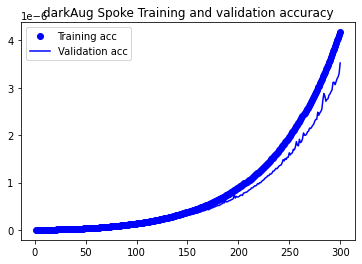

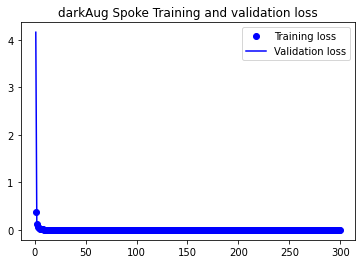

Last Train IOU Score:  4.171518412476871e-06
Last Train Loss Score:  1.9593480828916654e-06
Last Validation IOU Score:  3.521949793139356e-06
Last Validation Loss Score:  3.261777465013438e-06
darkAug
360
300


In [13]:
model_utility.display_results(f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.json")
print(type)
print(training_size)
print(epoch_num)

In [4]:

from tensorflow import keras

model = keras.models.load_model(f"models/{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5", compile=False)
print(type)
print(training_size)
print(epoch_num)

lightAug
820
300


# THIS IS CRAZY

# Lets test with images outside of train/test(light)

In [7]:
remaining_dataset = sorted(glob.glob("../datasets/"+"light_spokes_no_training/*.png"), key=get_order)

In [8]:
len(remaining_dataset)

797

In [9]:
remaining_test = []
filenames = []

for img_path in remaining_dataset:
    filenames.append(img_path.split("/")[-1])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    remaining_test.append(img)

In [10]:
remaining_test = normalize(np.array(remaining_test), axis=1)

W1630725193.png 234


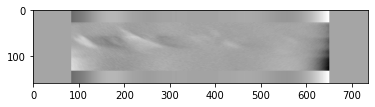

1/1 [==============================] - 0s 35ms/step


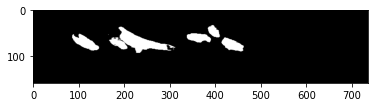

In [16]:
for filename, img in zip(filenames[226:236], remaining_test[226:236]):
    img = remaining_test[234]
    filename = filenames[234]
    print("W1630725193.png", filenames.index("W1630725193.png"))

    plt.imshow(img, cmap="gray")
    plt.show()
    img = img.reshape((1, 160, 736))    



    prediction = model.predict(img)
    plt.imshow(prediction[0], cmap='gray')
    plt.show()
    print()

    prediction = prediction.reshape((160, 736))
    plt.imsave(fname=f"testing/light_spoke_examples/lightAug_on_light_{'W1630725193'}_result.png", arr=prediction, cmap='gray', format='png')


    prediction = []
    break
    

# Lets test with images outside of train/test(Dark)

In [137]:
dark_remaining_dataset = sorted(glob.glob("../datasets/"+"dark_spokes_no_training/*.png"), key=get_order)
len(dark_remaining_dataset)

192

In [138]:
dark_remaining_test = []
dark_filenames = []

for dark_img_path in dark_remaining_dataset:
    dark_filenames.append(dark_img_path.split("/")[-1])
    img = cv2.imread(dark_img_path, cv2.IMREAD_GRAYSCALE)
    dark_remaining_test.append(img)

In [139]:
dark_remaining_test = normalize(np.array(dark_remaining_test), axis=1)

W1601167816 84


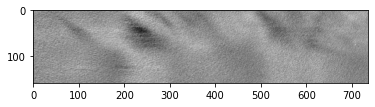

1/1 [==============================] - 0s 22ms/step


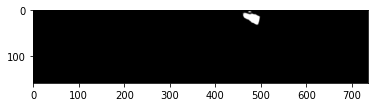

In [141]:
for filename, img in zip(dark_filenames[80:90], dark_remaining_test[80:90]):
    # img = dark_remaining_test[84]
    # filename = dark_filenames[84]
    print(filename, dark_filenames.index(filename))



    plt.imshow(img, cmap="gray")
    plt.show()
    img = img.reshape((1, 160, 736))    



    prediction = model.predict(img)
    prediction = prediction.reshape((160, 736))

    plt.imshow(prediction, cmap='gray')
    plt.show()

    # plt.imsave(fname=f"testing/dark_spoke_examples/dark_{'W1601167816'}_result.png", arr=prediction, cmap='gray', format='png')



    prediction = []
    # break
